In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import statistics
import seaborn as sns
import re
from itertools import chain
from collections import Counter
import math
from scipy.stats import chi2_contingency

In [2]:
pd.options.display.max_colwidth = 50

# A. An overview of the dataset

#### 1. Import the data as a pandas DataFrame into your notebook.

In [3]:
df = pd.read_pickle('data_385k.pkl', compression='zip')

#### 2. Check the number of rows and columns. You should have 385’384 samples and 99 columns.

In [4]:
df.shape

(385384, 99)

#### 3. Display a few entries from the DataFrame.

In [5]:
df.head(10)

,alcohol_by_volume,barcode,calcium_per_hundred,calcium_unit,carbohydrates_per_hundred,carbohydrates_per_portion,carbohydrates_unit,cholesterol_per_hundred,cholesterol_unit,copper_cu_per_hundred,...,vitamin_b5_panthothenic_acid_per_hundred,vitamin_b5_panthothenic_acid_unit,vitamin_b6_pyridoxin_per_hundred,vitamin_b6_pyridoxin_unit,vitamin_c_ascorbic_acid_per_hundred,vitamin_c_ascorbic_acid_unit,vitamin_d_d2_d3_international_units_per_hundred,vitamin_d_d2_d3_international_units_unit,zinc_per_hundred,zinc_unit
0,0.0,8001772000030,NaN,NaN,75.00,37.50,g,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,7610809001066,NaN,NaN,1.50,1.13,g,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,8002530159021,NaN,NaN,52.68,NaN,g,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,3033715065788,NaN,NaN,70.40,11.97,g,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,7610848492740,NaN,NaN,37.00,7.40,g,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,7610100033247,NaN,NaN,11.10,1.90,g,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,76145513,NaN,NaN,60.50,15.00,g,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,7610800826040,NaN,NaN,70.00,NaN,g,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,7611654576754,NaN,NaN,80.00,8.00,g,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,5000159023061,NaN,NaN,61.60,NaN,g,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 4. Check the data type for each column. Create separate lists to hold the names of columns of the same data type.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385384 entries, 0 to 385383
Data columns (total 99 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   alcohol_by_volume                                385384 non-null  float64
 1   barcode                                          385384 non-null  object 
 2   calcium_per_hundred                              264979 non-null  float64
 3   calcium_unit                                     265086 non-null  object 
 4   carbohydrates_per_hundred                        351551 non-null  float64
 5   carbohydrates_per_portion                        11480 non-null   float64
 6   carbohydrates_unit                               351828 non-null  object 
 7   cholesterol_per_hundred                          270282 non-null  float64
 8   cholesterol_unit                                 270329 non-null  object 
 9   copper_cu_per_h

In [7]:
cont_cols = list(df.select_dtypes(include='number').columns)
obj_cols = list(df.select_dtypes(include='object').columns)

# B. Preliminary Exploratory Data Analysis

#### 1. Are there any duplicated products in the data? Can you remove them? What is the shape of the remaining data?

In [8]:
# droping the barcode (considered as index here) to check if there are more duplicated rows
dup = df.drop(labels=["barcode"], axis=1).duplicated().sum() # by default, keeps the firs occurrence
print('There are {} duplicated rows that can be removed'.format(dup.sum()))

There are 10500 duplicated rows that can be removed


In [9]:
df = df.drop_duplicates()
df.shape

(374884, 99)

#### 2. Show the proportion of missing values in the data using appropriate visualizations and numerical summaries.

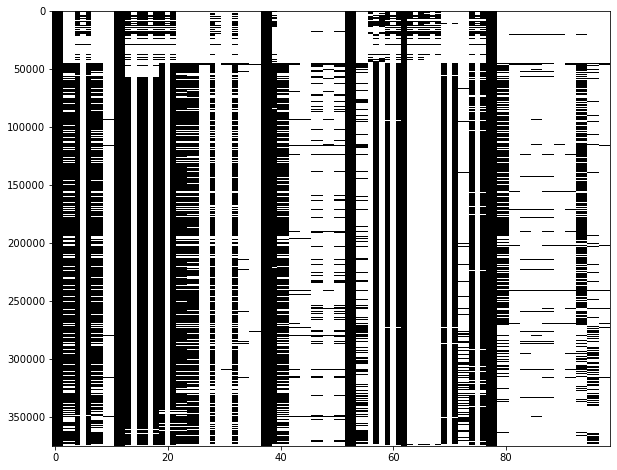

In [10]:
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray");

We observe 3 main points:
* All rows have values for the same columns (for example the first column) - it might be compulsory information that must be provided for a product
* For other columns (white ones), the vast majority of rows has missing values - this information might be relevant/available only for a specific product
* Rows from 0 - 50000 present a higher proportion of missing values than the rest of the dataset

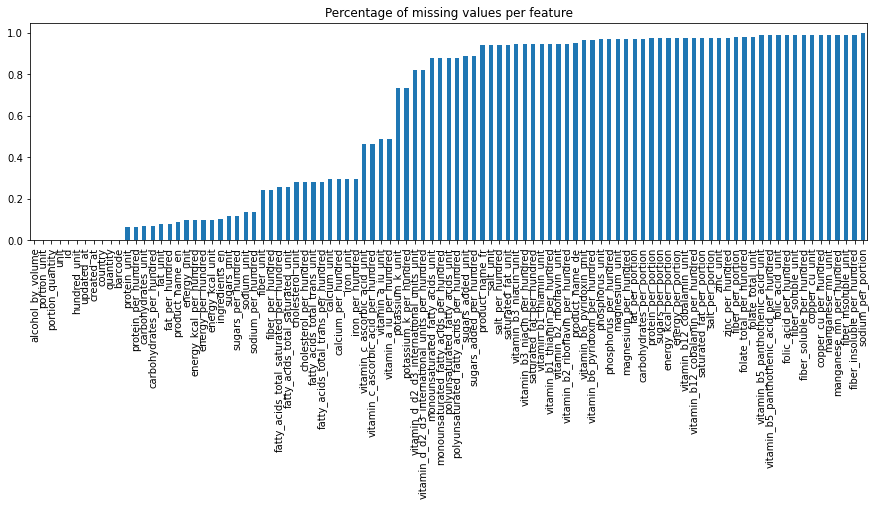

In [11]:
# Proportion of missing values per feature
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values per feature");

In [12]:
missing_threshold = 0.4
print('{} columns have a percentage larger than {}% of missing values'.format((df.isna().mean() > missing_threshold).sum(),
     missing_threshold * 100))

60 columns have a percentage larger than 40.0% of missing values


#### 3. Now that you know the extent of missing values in the data, you should address them. Your goal is to keep as much data as possible in your DataFrame. What is the shape of the remaining data?

In [13]:
df.shape

(374884, 99)

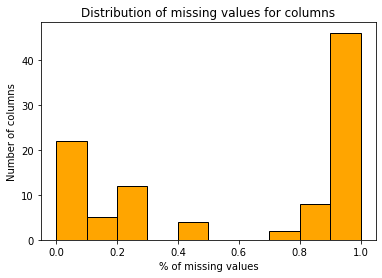

In [14]:
hist = df.isna().mean(axis=0).plot.hist(bins=np.arange(0, 1 + 0.1, 0.1), color="orange", edgecolor="black")
hist.set_xlabel("% of missing values")
hist.set_ylabel("Number of columns")
hist.set_title("Distribution of missing values for columns")
plt.show()

In [15]:
# drop features with more than 30% of missing values
# thresh=N requires that a column has at least N non-NaNs to survive
df = df.dropna(thresh=df.shape[0] * 0.70, axis=1)

In [16]:
print('{} columns are kept after this first cleaning step.'.format(df.shape[1]))

39 columns are kept after this first cleaning step.


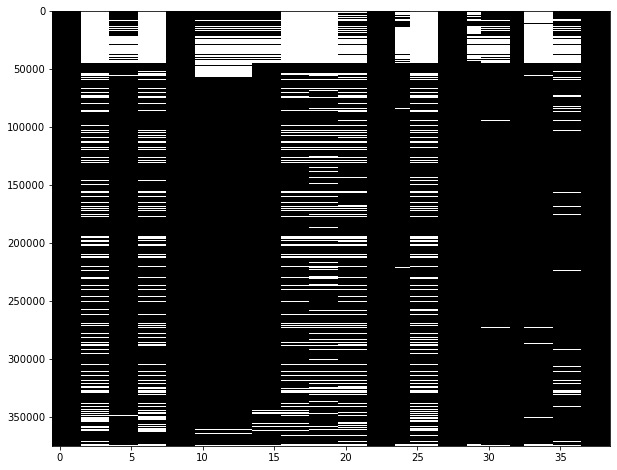

In [17]:
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray");

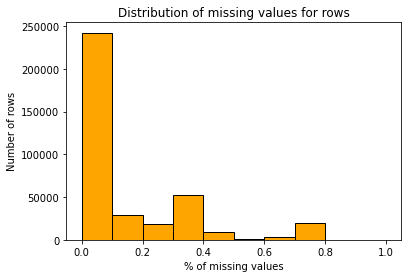

In [18]:
hist = df.isna().mean(axis=1).plot.hist(bins=np.arange(0, 1 + 0.1, 0.1), color="orange", edgecolor="black")
hist.set_xlabel("% of missing values")
hist.set_ylabel("Number of rows")
hist.set_title("Distribution of missing values for rows")
plt.show()

In [19]:
df.shape

(374884, 39)

In [20]:
# keep rows that have more than 60% of values
# thresh=N requires that a row has at least N non-NaNs to survive
df = df.dropna(thresh=df.shape[1] * 0.60, axis=0)

In [21]:
print('{} rows are kept after this second cleaning step. {} rows where removed'.format(df.shape[0], 374884 - df.shape[0]))

342705 rows are kept after this second cleaning step. 32179 rows where removed


In [22]:
# resetting index
df.reset_index(inplace=True, drop=True)

#### 4. Let’s continue exploring the categorical variables in more detail. What is the number of unique values in categorical variables? Show the proportion of samples in each categorical level in the variables country and unit using appropriate visualizations.

In [23]:
# get new list of object columns
obj_cols = list(df.select_dtypes(include='object').columns)

In [24]:
df['id'].nunique()

342705

In [25]:
df[obj_cols].nunique()

barcode                             342618
calcium_unit                             1
carbohydrates_unit                       1
cholesterol_unit                         1
country                                  6
created_at                           18536
energy_kcal_unit                         1
energy_unit                              1
fat_unit                                 1
fatty_acids_total_saturated_unit         1
fatty_acids_total_trans_unit             1
fiber_unit                               1
hundred_unit                             2
ingredients_en                      243208
iron_unit                                1
portion_unit                             5
product_name_en                     216938
protein_unit                             1
sodium_unit                              1
sugars_unit                              1
unit                                     6
updated_at                           18554
dtype: int64

In [26]:
print('{} over the {} categorical variables have only 1 unique value'.format((df[obj_cols].nunique()==1).sum(), len(obj_cols)))

13 over the 22 categorical variables have only 1 unique value


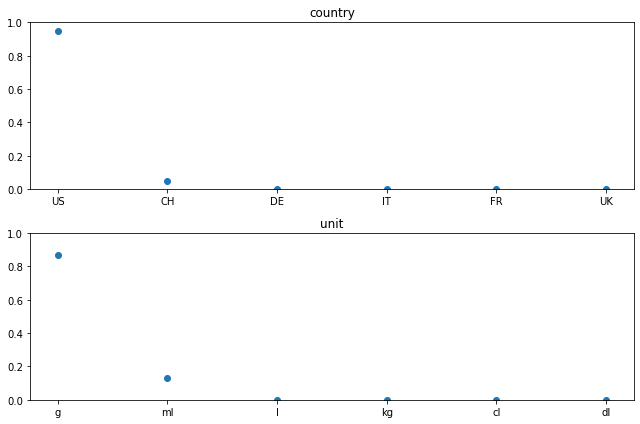

In [27]:
# Create figure object with 2 subplots
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(9, 6))

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df[['country','unit']].columns, axes.ravel()):

    # Selects one single feature and counts number of occurrences per unique value
    df[['country','unit']][col].value_counts(normalize=True).plot(

        # Plots this information in a figure with log-scaled y-axis
        title=col, lw=0, marker="o", ax=ax)
    ax.set_ylim([0, 1])
    
plt.tight_layout()

Both variables have one of the categories that are represented in a large proportion in the data (*US* for country and *g* for unit)

#### 5. Provide descriptive statistics (e.g., min/max/mean) and informative plots (e.g., histograms) of the numerical variables. You should obtain these plots as subplots.

In [28]:
# get new list of object columns
cont_cols = list(df.select_dtypes(include='number').columns)

In [29]:
df[cont_cols].describe().round().loc[['min', 'max', 'mean', 'std'],:]

,alcohol_by_volume,calcium_per_hundred,carbohydrates_per_hundred,cholesterol_per_hundred,energy_kcal_per_hundred,energy_per_hundred,fat_per_hundred,fatty_acids_total_saturated_per_hundred,fatty_acids_total_trans_per_hundred,fiber_per_hundred,id,iron_per_hundred,portion_quantity,protein_per_hundred,quantity,sodium_per_hundred,sugars_per_hundred
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,971.0,0.0,0.0,0.0,0.0,0.0,0.0
max,44.0,684000.0,6400.0,250000.0,39600.0,165686.0,1900.0,1000.0,615.0,1730.0,376940.0,769231.0,2000.0,1040.0,10000.0,25833.0,5800.0
mean,0.0,117.0,34.0,58.0,273.0,1143.0,13.0,5.0,0.0,3.0,200987.0,8.0,3.0,7.0,93.0,1.0,17.0
std,0.0,2559.0,40.0,1910.0,259.0,1081.0,19.0,8.0,1.0,6.0,101231.0,1581.0,26.0,10.0,123.0,68.0,31.0


In [30]:
df[cont_cols].median()

alcohol_by_volume                               0.00
calcium_per_hundred                            36.00
carbohydrates_per_hundred                      23.68
cholesterol_per_hundred                         0.00
energy_kcal_per_hundred                       269.00
energy_per_hundred                           1125.00
fat_per_hundred                                 5.41
fatty_acids_total_saturated_per_hundred         2.00
fatty_acids_total_trans_per_hundred             0.00
fiber_per_hundred                               1.60
id                                         201944.00
iron_per_hundred                                1.00
portion_quantity                                0.00
protein_per_hundred                             4.55
quantity                                       45.00
sodium_per_hundred                              0.26
sugars_per_hundred                              6.43
dtype: float64

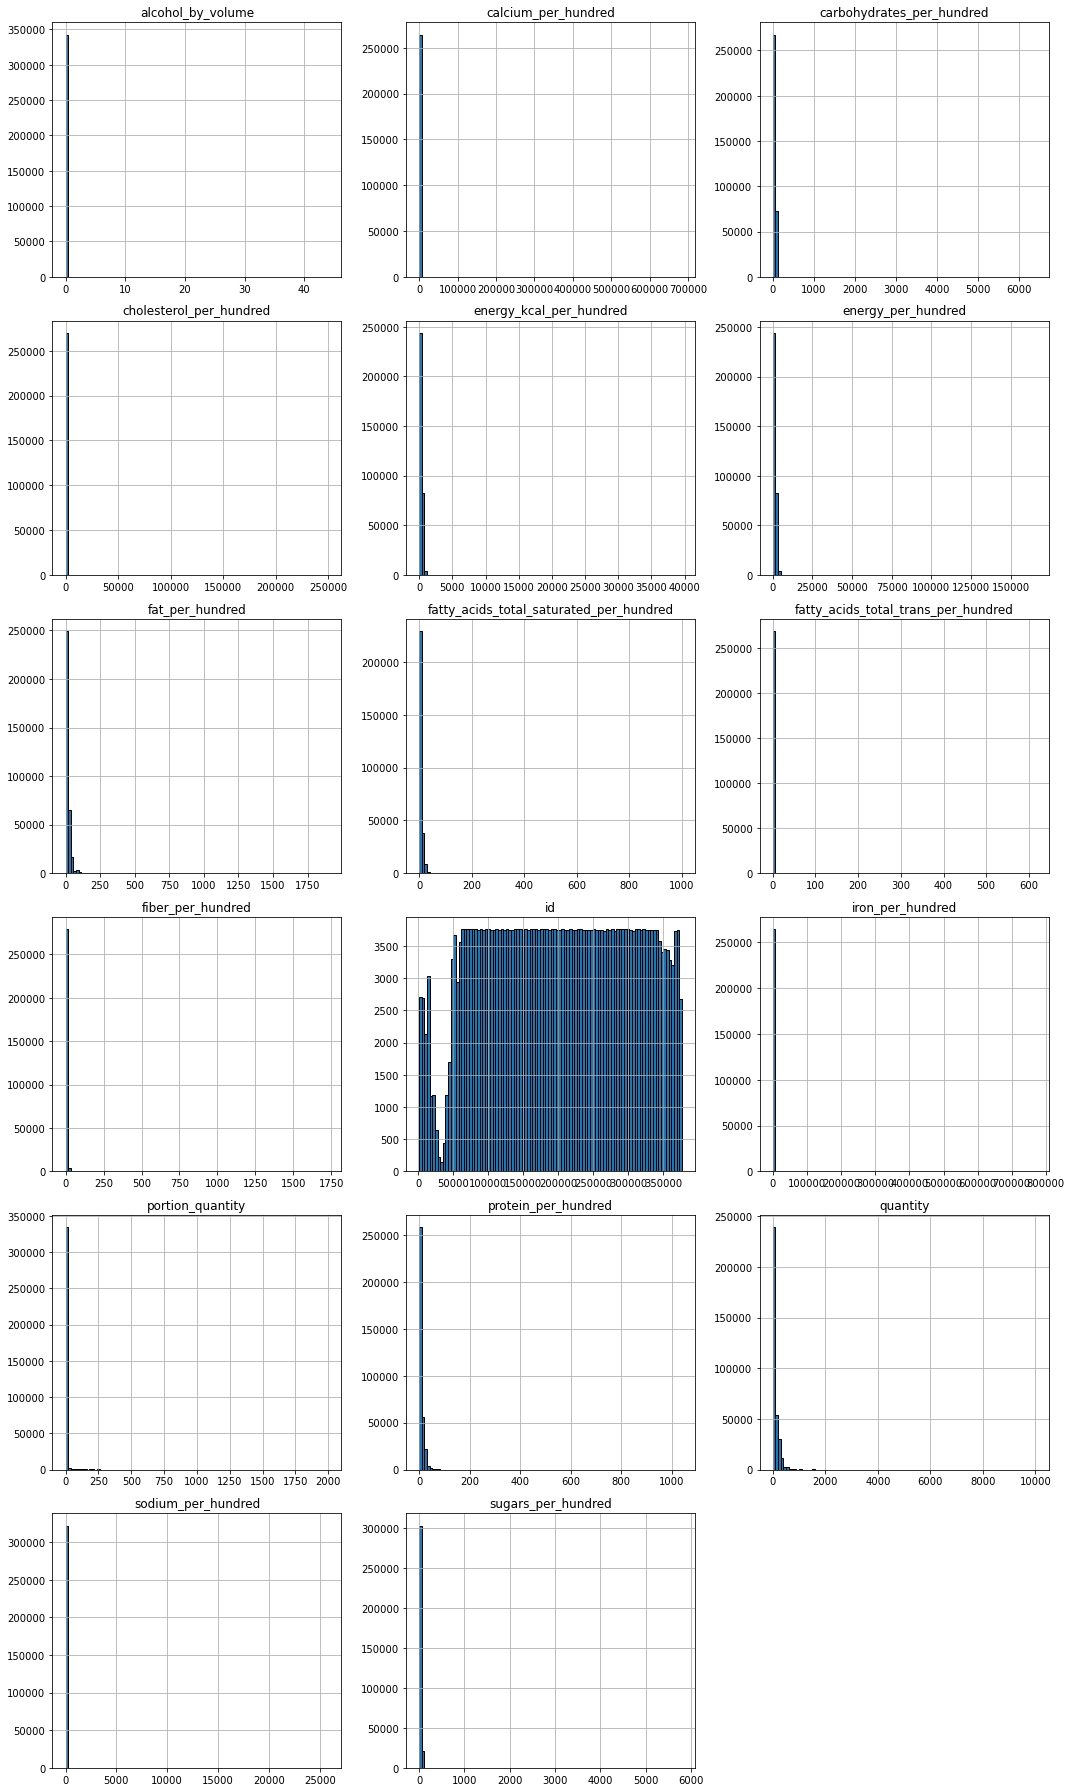

In [31]:
# Plots the histogram for each numerical feature in a separate subplot
df[cont_cols].hist(bins=100, figsize=(15, 25), layout=(-1, 3), edgecolor="black")
plt.tight_layout()

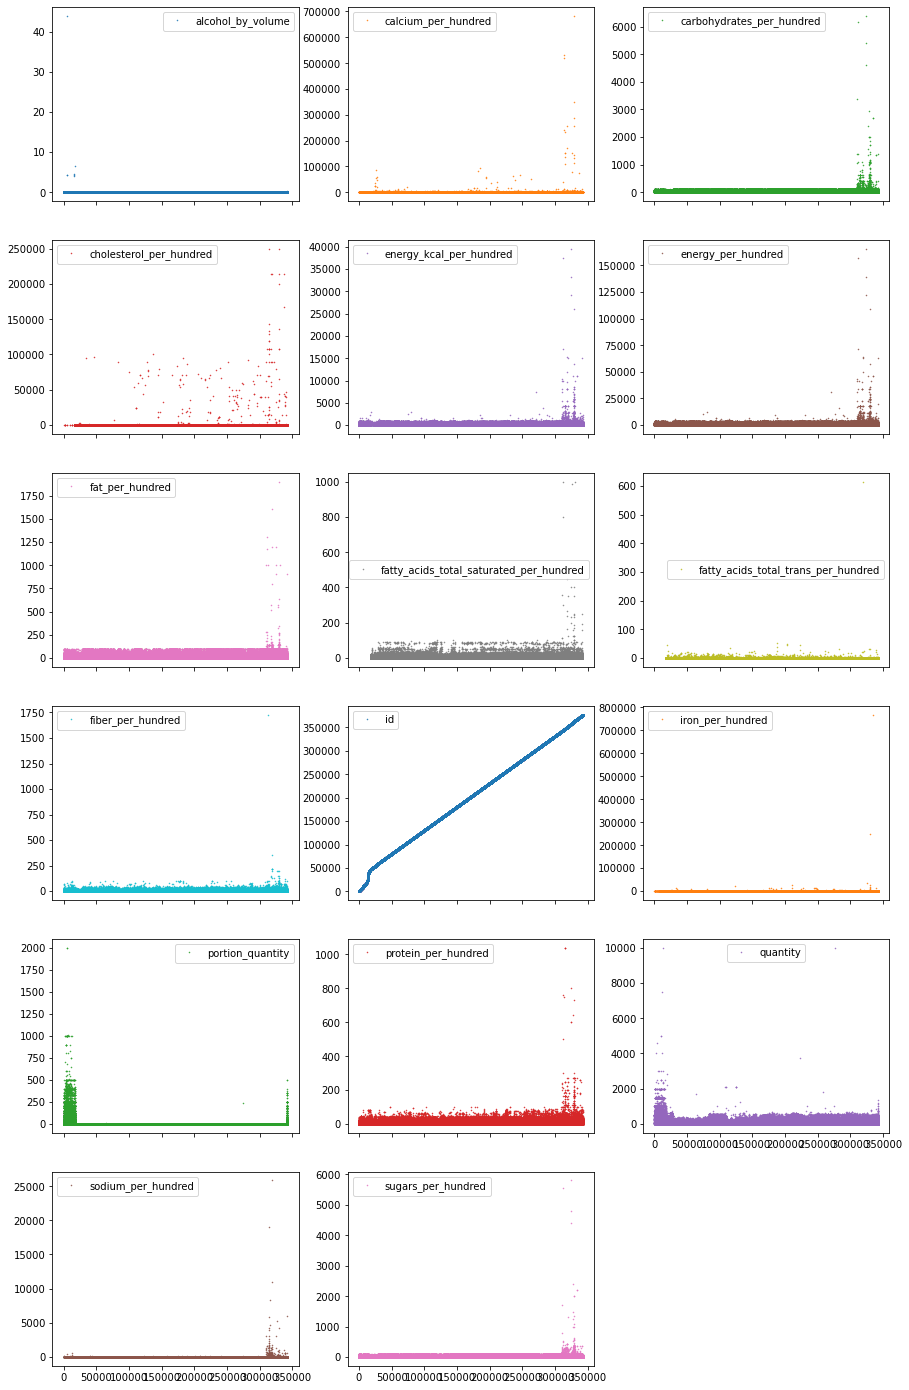

In [32]:
df[cont_cols].plot(lw=0, marker=".", subplots=True, layout=(-1, 3), figsize=(15, 25), markersize=1);

Some food products in the last 20'000 rows have higher ingridients and nutritional facts values (e.g carbohydrates_per_hundred, energy_per_hundred, sugars_per_hundred). For other features (e.g portion_quantity), the first 20'000 rows represents higher values. Comparing the median with the range of values for each variable, it seems that outliers are present for some if the features (e.g alcohol_by_volume, iron_per_hundred)

#### 6. Address any unrealistic values or errors. The statistics and your plots of the per_hundred columns (e.g. protein_per_hundred, fat_per_hundred, etc.) can help you spot these values. Afterwards re-do the descriptive statistics and plots to check everything is ok now. Below are some additional tips and hints.

* Create a new list to hold the columns with the per_hundred suffix in their names.
* The range of acceptable values in each column depends on the unit of each column. You can find the unit of each column in the associated unit column. For example, the protein_per_hundred column unit is found in the protein_unit column, etc.
* The unit of the protein_per_hundred column is g, which means that the values in this column should range between 0 and 100.
* If a column’s unit is mg, then the values should range between 0 and 10^5.
* If a column’s unit is in International units (IU), you can use the “Mass equivalents of 1 IU” indicated on this Wikipedia page to define an upper threshold value.

In [33]:
cols_by_volume = [i for i in cont_cols if 'by_volume' in i]
cols_per_hundred = [i for i in cont_cols if 'per_hundred' in i]
cols_quantity = [i for i in cont_cols if 'quantity' in i]

In [34]:
cols_unit = [i.replace('per_hundred', 'unit') for i in cols_per_hundred]

In [35]:
df.hundred_unit.unique()

array(['g', 'ml'], dtype=object)

In [36]:
for i in cols_unit:
    print(i, ': ', df[i].unique())

calcium_unit :  [nan 'mg']
carbohydrates_unit :  ['g' nan]
cholesterol_unit :  [nan 'mg']
energy_kcal_unit :  ['kCal' nan]
energy_unit :  ['kJ' nan]
fat_unit :  ['g' nan]
fatty_acids_total_saturated_unit :  [nan 'g']
fatty_acids_total_trans_unit :  [nan 'g']
fiber_unit :  ['g' nan]
iron_unit :  [nan 'mg']
protein_unit :  ['g' nan]
sodium_unit :  [nan 'g']
sugars_unit :  ['g' nan]


In [37]:
unit_max = {'g': 100,
            'mg': 100000,
            'ml': 100000,
            'kCal': 884,
            'kJ': 3700}

In [38]:
for i in cols_unit:
    df[i + '_max'] = df[i].map(unit_max)

In [39]:
# df['value_max'] = df.hundred_unit.map(unit_max)

In [40]:
for i in cols_per_hundred:
    print(i, ': ', ((df[i] > df[i.replace('per_hundred', 'unit_max')]).mean() * 100).round(2), '%')

calcium_per_hundred :  0.01 %
carbohydrates_per_hundred :  0.22 %
cholesterol_per_hundred :  0.01 %
energy_kcal_per_hundred :  0.24 %
energy_per_hundred :  0.23 %
fat_per_hundred :  0.04 %
fatty_acids_total_saturated_per_hundred :  0.01 %
fatty_acids_total_trans_per_hundred :  0.0 %
fiber_per_hundred :  0.01 %
iron_per_hundred :  0.0 %
protein_per_hundred :  0.05 %
sodium_per_hundred :  0.05 %
sugars_per_hundred :  0.11 %


In [41]:
# for i in cols_per_hundred:
#     print(i, ': ', ((df[i] > df['value_max']).mean() * 100).round(2), '%')

In [42]:
# remove rows with unrealistic values
df['above_threshold'] = 0
for i in cols_per_hundred:
    df.loc[(df[i] > df[i.replace('per_hundred', 'unit_max')]), 'above_threshold'] += 1

In [43]:
print('{} rows will be deleted'.format(df[df.above_threshold == 1].shape[0]))

646 rows will be deleted


In [44]:
df.drop(df[df.above_threshold > 0].index, inplace=True)

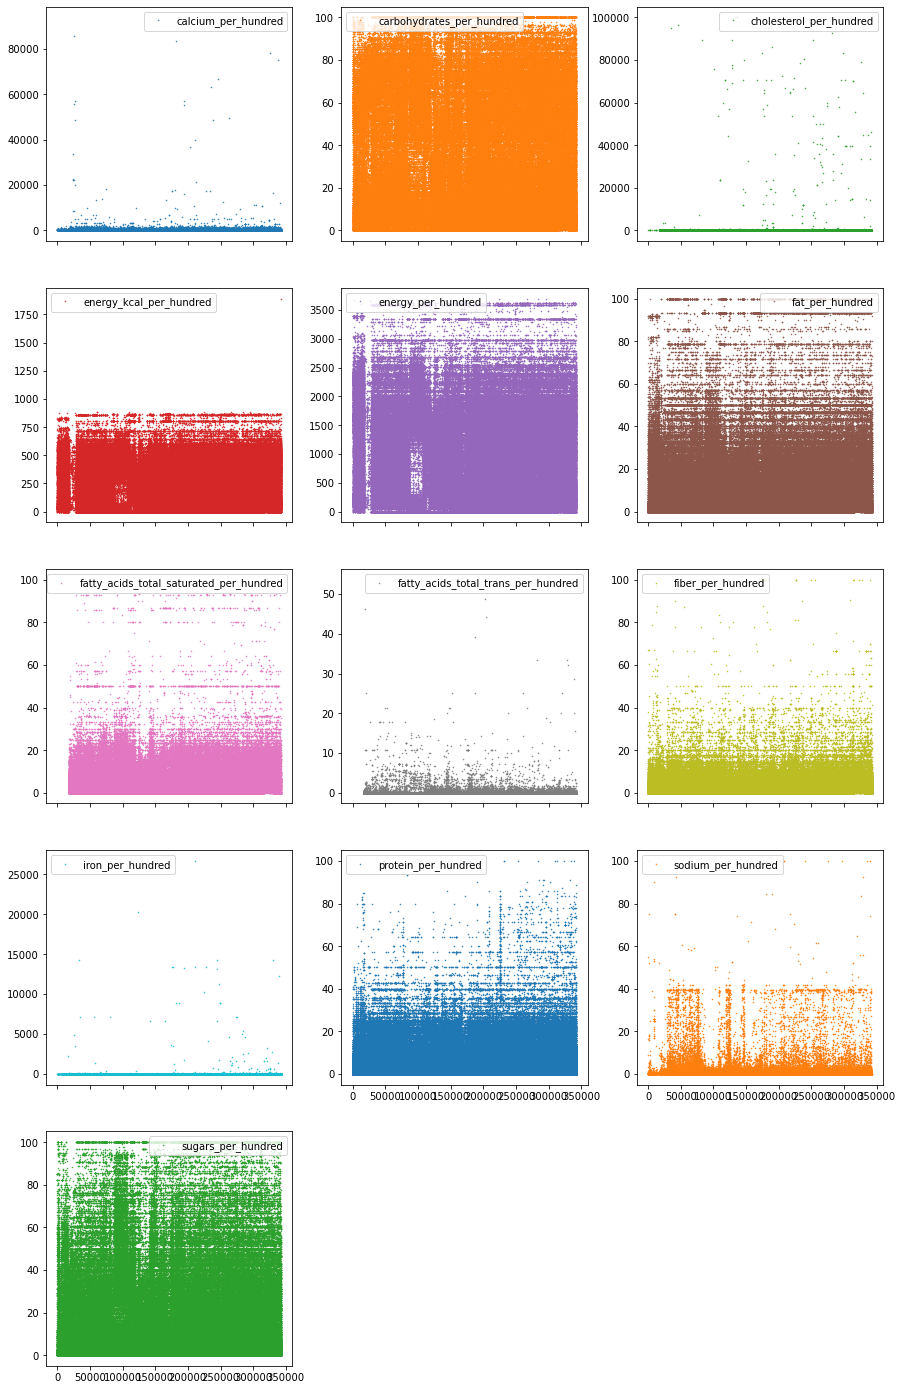

In [45]:
df[cols_per_hundred].plot(lw=0, marker=".", subplots=True, layout=(-1, 3), figsize=(15, 25), markersize=1);

In [46]:
df[cols_per_hundred].describe().round(2).loc[['min', 'max', 'mean', 'std'],:]

,calcium_per_hundred,carbohydrates_per_hundred,cholesterol_per_hundred,energy_kcal_per_hundred,energy_per_hundred,fat_per_hundred,fatty_acids_total_saturated_per_hundred,fatty_acids_total_trans_per_hundred,fiber_per_hundred,iron_per_hundred,protein_per_hundred,sodium_per_hundred,sugars_per_hundred
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,93750.00,100.00,100000.00,1890.00,3698.66,100.00,100.00,53.57,100.00,26666.67,100.00,100.00,100.00
mean,97.94,33.39,41.30,268.63,1123.83,12.41,4.83,0.03,2.88,3.33,7.16,0.68,16.45
std,561.40,29.14,1136.39,187.25,783.16,16.60,7.10,0.48,4.57,126.58,8.54,2.86,21.26


In [47]:
df[cols_per_hundred].median()

calcium_per_hundred                          36.00
carbohydrates_per_hundred                    23.53
cholesterol_per_hundred                       0.00
energy_kcal_per_hundred                     267.00
energy_per_hundred                         1117.13
fat_per_hundred                               5.36
fatty_acids_total_saturated_per_hundred       1.96
fatty_acids_total_trans_per_hundred           0.00
fiber_per_hundred                             1.60
iron_per_hundred                              1.00
protein_per_hundred                           4.55
sodium_per_hundred                            0.26
sugars_per_hundred                            6.41
dtype: float64

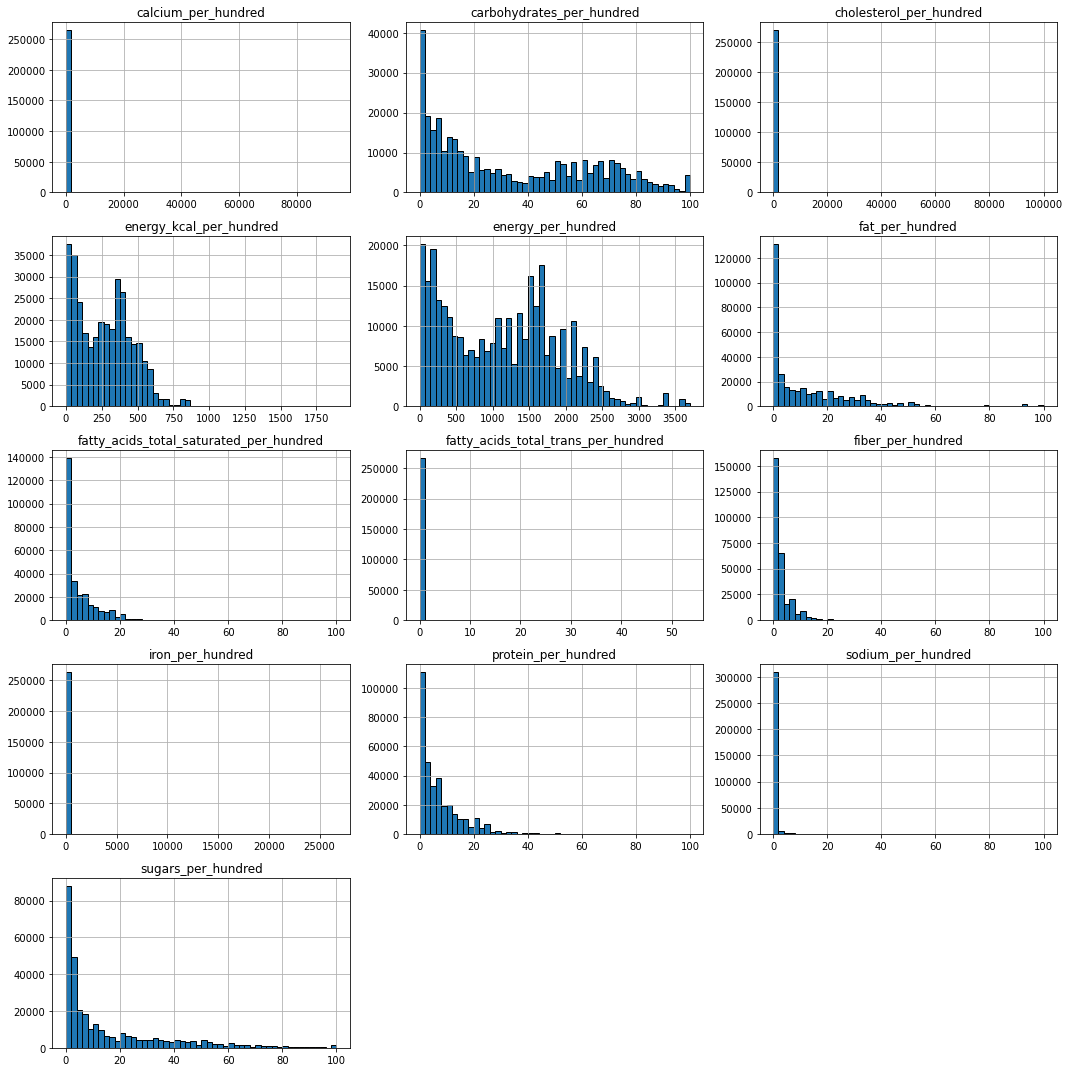

In [48]:
df[cols_per_hundred].hist(bins=50, figsize=(15, 15), layout=(-1, 3), edgecolor="black")
plt.tight_layout()

After thresholding our variables, we can see now that, as expected, all distributions are right skewed. The energy (in kJ) shows a bi-modal distribution (around 0 and around 1600). For calcium, cholesterol, fatty acids total trans, iron, and sodium, we observe that the majority of the values lay towards the lower range of possible values. There are still some extreme values present in the dataset.

#### 7. Do you spot any other inconsistencies in the data? What about the sum of a product’s protein, fat, carbohydrates, salt, and fiber content?

In [49]:
df['macro_sum'] = df[['protein_per_hundred','fat_per_hundred','carbohydrates_per_hundred','sodium_per_hundred',
    'fiber_per_hundred']].sum(axis=1)

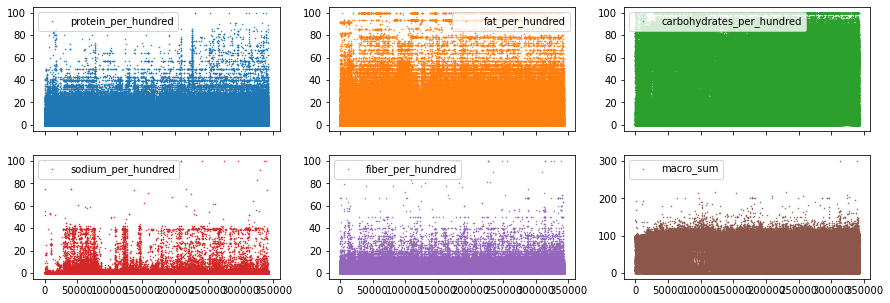

In [50]:
df[['protein_per_hundred','fat_per_hundred','carbohydrates_per_hundred','sodium_per_hundred',
    'fiber_per_hundred','macro_sum']].plot(lw=0, marker=".", 
                                           subplots=True, layout=(-1, 3), figsize=(15, 5), markersize=1);

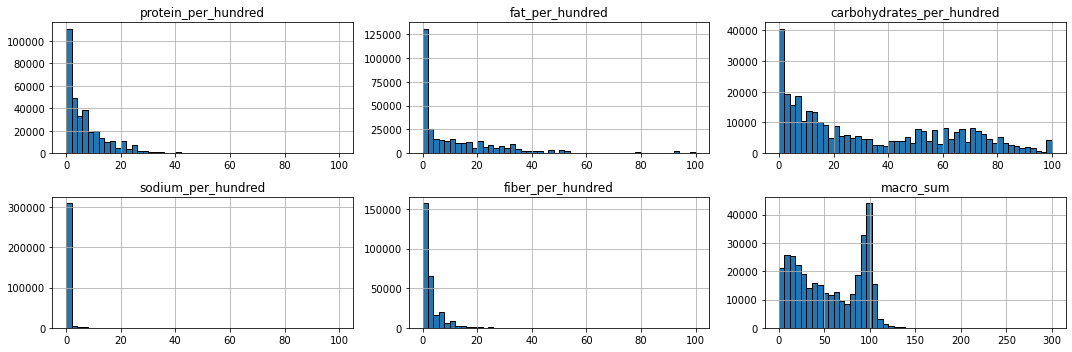

In [51]:
df[['protein_per_hundred','fat_per_hundred','carbohydrates_per_hundred','sodium_per_hundred',
    'fiber_per_hundred','macro_sum']].hist(bins=50, figsize=(15, 5), layout=(-1, 3), edgecolor='black')
plt.tight_layout()

In [52]:
df[['protein_per_hundred','fat_per_hundred','carbohydrates_per_hundred','sodium_per_hundred',
    'fiber_per_hundred','macro_sum']].describe().round(2)

,protein_per_hundred,fat_per_hundred,carbohydrates_per_hundred,sodium_per_hundred,fiber_per_hundred,macro_sum
count,340384.00,337128.00,339701.00,320968.00,282856.00,341130.00
mean,7.16,12.41,33.39,0.68,2.88,55.70
std,8.54,16.60,29.14,2.86,4.57,35.69
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.42,0.00,6.67,0.03,0.00,21.46
50%,4.55,5.36,23.53,0.26,1.60,53.84
75%,10.00,20.00,60.00,0.57,3.60,92.70
max,100.00,100.00,100.00,100.00,100.00,300.00


In [53]:
df[['protein_per_hundred','fat_per_hundred','carbohydrates_per_hundred','sodium_per_hundred',
    'fiber_per_hundred','macro_sum']].median()

protein_per_hundred           4.55
fat_per_hundred               5.36
carbohydrates_per_hundred    23.53
sodium_per_hundred            0.26
fiber_per_hundred             1.60
macro_sum                    53.84
dtype: float64

A bi-modal distribution is observed for the sum of protein, fat, carbohydrates, salt, and fiber content. It might be the result of having two categories of products in the dataset: those containing low macronutrients content, and those with higher values.

#### 8. Despite removing recording errors from the per_hundred columns, some of them still contain “extreme” values, which are distinct from the rest of the data points. Your goal is to pick a few variables from the per_hundred list and address outliers.

In [54]:
'calcium_per_hundred', 'cholesterol_per_hundred', 'iron_per_hundred', 'fatty_acids_total_trans_per_hundred', 'sodium_per_hundred'

('calcium_per_hundred',
 'cholesterol_per_hundred',
 'iron_per_hundred',
 'fatty_acids_total_trans_per_hundred',
 'sodium_per_hundred')

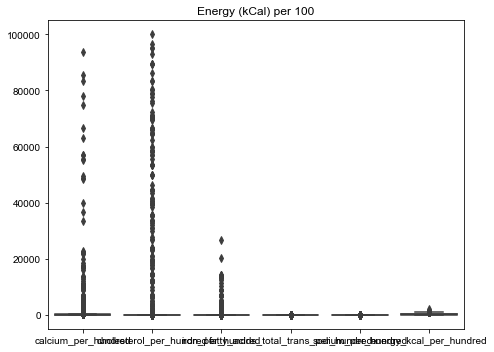

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (7, 5))
sns.boxplot(data=df[['calcium_per_hundred', 'cholesterol_per_hundred', 'iron_per_hundred', 
                     'fatty_acids_total_trans_per_hundred', 'sodium_per_hundred',
                     'energy_kcal_per_hundred']]).set_title('Energy (kCal) per 100')
sns.set_style('white')
fig.tight_layout()

In [56]:
df[['calcium_per_hundred', 'cholesterol_per_hundred', 'iron_per_hundred', 
                     'fatty_acids_total_trans_per_hundred', 'sodium_per_hundred',
                     'energy_kcal_per_hundred']].describe()

,calcium_per_hundred,cholesterol_per_hundred,iron_per_hundred,fatty_acids_total_trans_per_hundred,sodium_per_hundred,energy_kcal_per_hundred
count,264248.000000,269460.000000,263884.000000,268149.000000,320968.000000,329286.000000
mean,97.935410,41.299392,3.333311,0.031815,0.684260,268.626873
std,561.395172,1136.392796,126.581372,0.475760,2.859026,187.246788
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.030000,90.000000
50%,36.000000,0.000000,1.000000,0.000000,0.260000,267.000000
75%,102.000000,24.000000,2.400000,0.000000,0.570000,400.000000
max,93750.000000,100000.000000,26666.670000,53.570000,100.000000,1890.000000


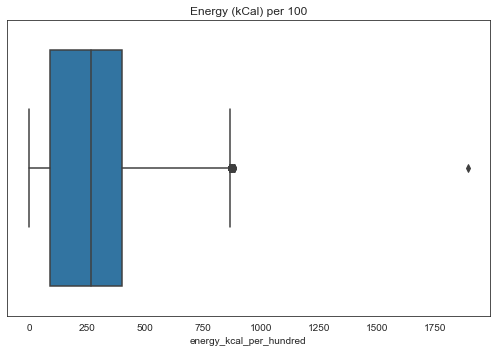

In [57]:
# energy_kcal_per_hundred
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (7, 5))
sns.boxplot(x='energy_kcal_per_hundred', data=df).set_title('Energy (kCal) per 100')
sns.set_style('white')
fig.tight_layout()

In [58]:
df.drop(df[df.energy_kcal_per_hundred > 1000].index, inplace=True)

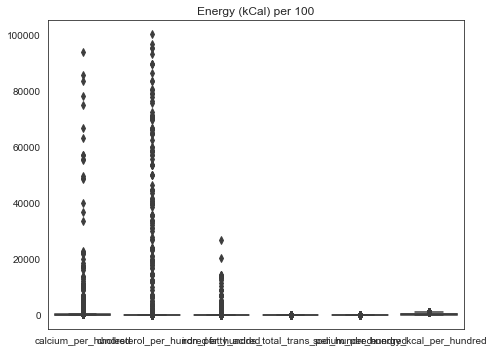

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (7, 5))
sns.boxplot(data=df[['calcium_per_hundred', 'cholesterol_per_hundred', 'iron_per_hundred', 
                     'fatty_acids_total_trans_per_hundred', 'sodium_per_hundred',
                     'energy_kcal_per_hundred']]).set_title('Energy (kCal) per 100')
sns.set_style('white')
fig.tight_layout()

In [60]:
# zscore
zscores_df = (df[['calcium_per_hundred', 'cholesterol_per_hundred', 
                  'iron_per_hundred','fatty_acids_total_trans_per_hundred',
                  'sodium_per_hundred']] - df[['calcium_per_hundred','cholesterol_per_hundred',
                                               'iron_per_hundred','fatty_acids_total_trans_per_hundred', 
                                               'sodium_per_hundred']].mean()) / (df[['calcium_per_hundred',
                                               'cholesterol_per_hundred','iron_per_hundred',
                                               'fatty_acids_total_trans_per_hundred','sodium_per_hundred']].std())
zfilter = np.abs(zscores_df) > 3

In [61]:
zfilter.sum(axis=0)

calcium_per_hundred                     292
cholesterol_per_hundred                 140
iron_per_hundred                         72
fatty_acids_total_trans_per_hundred    1405
sodium_per_hundred                     3499
dtype: int64

In [62]:
print('Using the zscore method to spot outliers, {} rows would be deleted'.format(df.loc[zfilter.any(axis=1), :].shape[0]))

Using the zscore method to spot outliers, 5343 rows would be deleted


In [63]:
# interquartile range
Q1 = np.nanpercentile(df[['calcium_per_hundred', 'cholesterol_per_hundred', 
                  'iron_per_hundred','fatty_acids_total_trans_per_hundred',
                  'sodium_per_hundred']], 25, axis=0)
Q3 = np.nanpercentile(df[['calcium_per_hundred', 'cholesterol_per_hundred', 
                  'iron_per_hundred','fatty_acids_total_trans_per_hundred',
                  'sodium_per_hundred']], 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [64]:
boxplot_filter = (df[['calcium_per_hundred', 'cholesterol_per_hundred', 
                  'iron_per_hundred','fatty_acids_total_trans_per_hundred',
                  'sodium_per_hundred']] < lower_bound) | (df[['calcium_per_hundred', 'cholesterol_per_hundred', 
                  'iron_per_hundred','fatty_acids_total_trans_per_hundred',
                  'sodium_per_hundred']] > upper_bound)
print("Number of outliers detected per feature using a boxplot:")
print(boxplot_filter.sum(axis=0))
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())

Number of outliers detected per feature using a boxplot:
calcium_per_hundred                    21094
cholesterol_per_hundred                32869
iron_per_hundred                       11894
fatty_acids_total_trans_per_hundred     5506
sodium_per_hundred                     19078
dtype: int64
Total number of outliers detected: 90441


Given its distribution, it was expected that the IQ range will spot a higher number of outliers (more than 25%) for the studied features.

In [65]:
zfilter_any = zfilter.any(axis=1)
outliers = df.loc[zfilter_any, :]

In [66]:
df.drop(outliers.index, axis=0, inplace=True)

In [67]:
df.shape

(335786, 54)

# C. In-depth Exploratory Data Analysis

#### 1. What is the nutrients’ distribution per country? You can choose any subset of the nutrients you want to analyze (e.g. macronutrients, minerals, or vitamins).

In [68]:
vitamins = ['calcium_per_hundred', 'sodium_per_hundred', 'iron_per_hundred']
titles = ['Calcium', 'Sodium', 'Iron']

In [69]:
df[['country','id']].groupby('country').id.nunique()

country
CH     17042
DE       812
FR        36
IT       222
UK         1
US    317673
Name: id, dtype: int64

In [70]:
countries = list(df.country.unique())

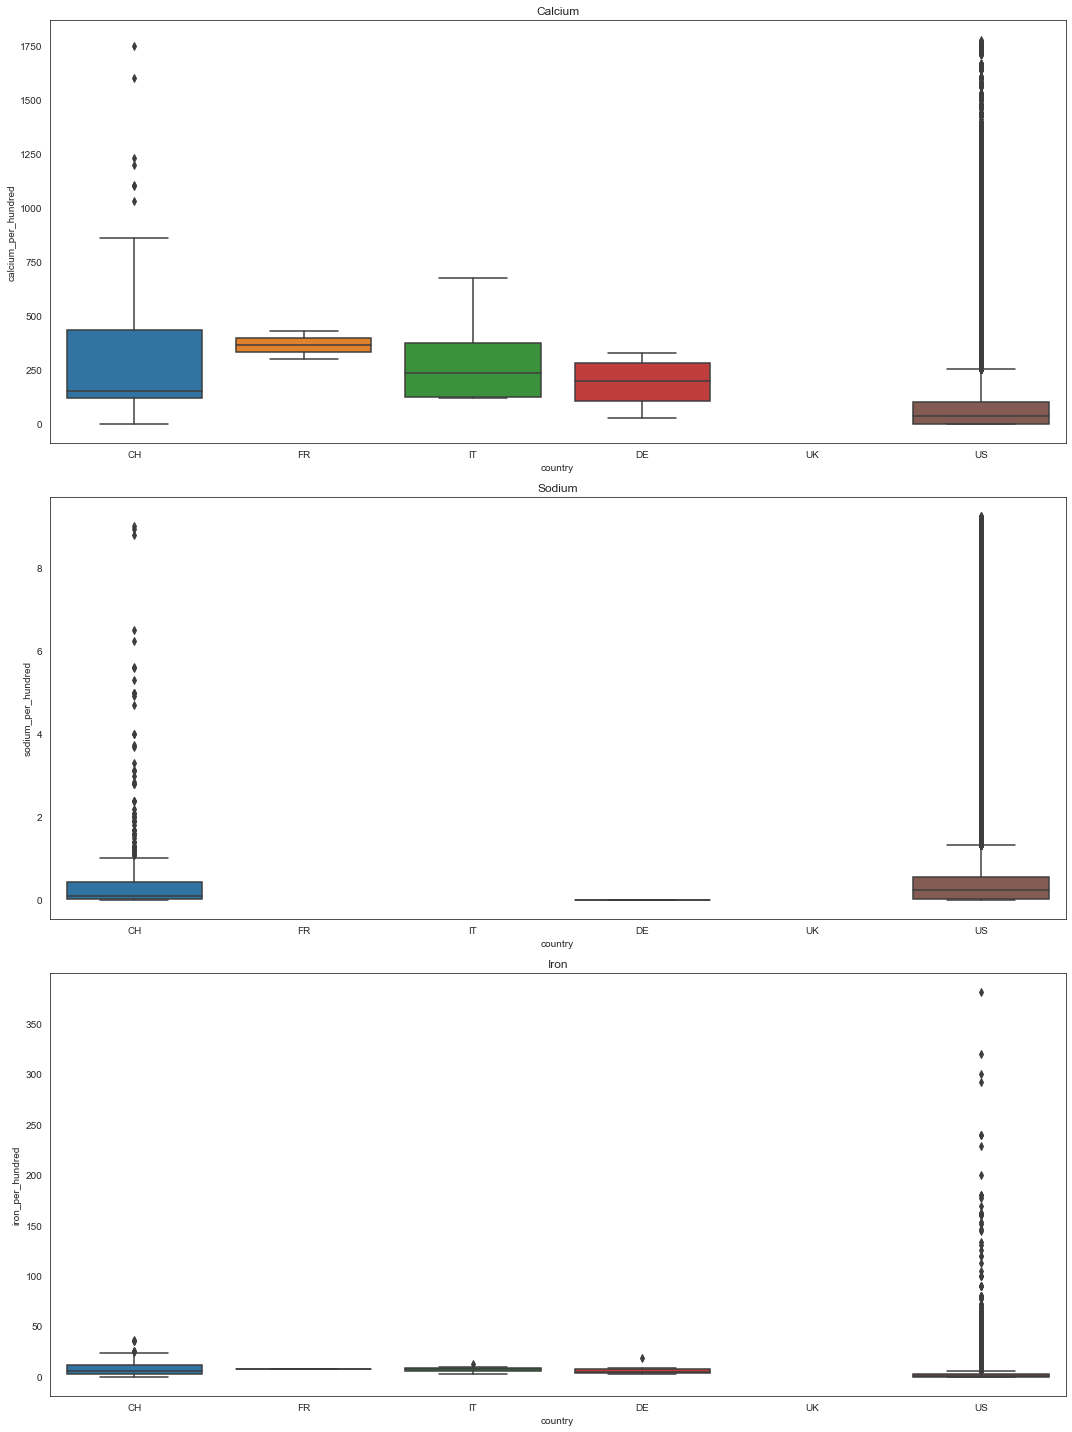

In [71]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (15, 20))
for i in range(0,3):
    sns.boxplot(x='country', y=vitamins[i], data=df,
                   ax=axes[i]).set_title(titles[i])

fig.tight_layout()

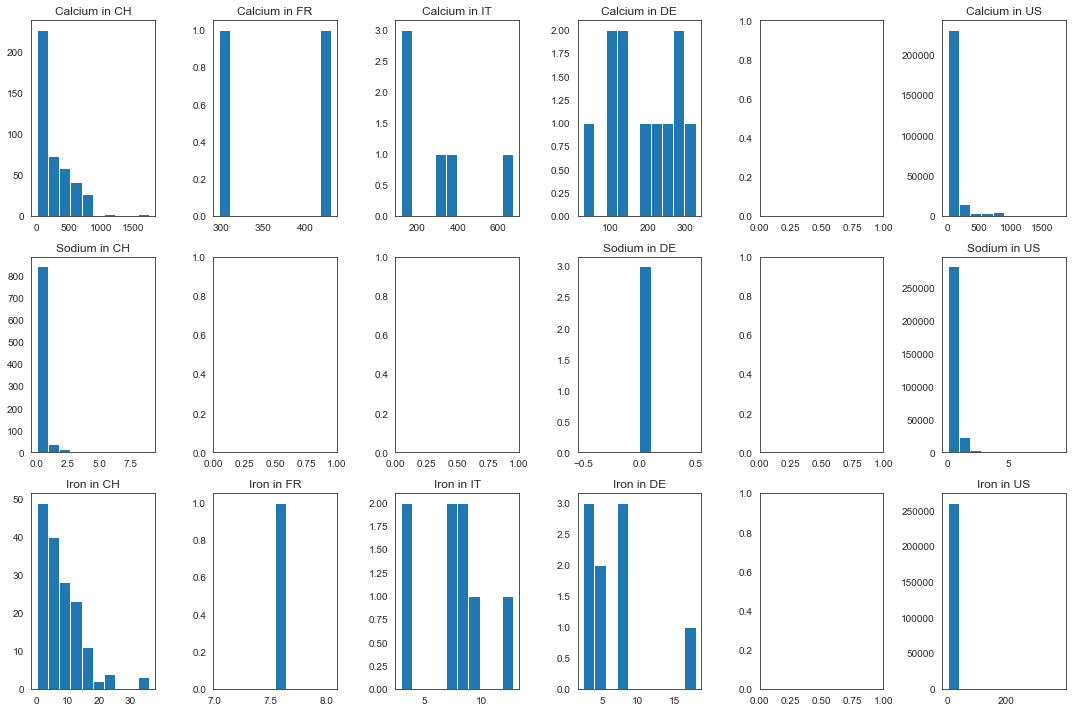

In [72]:
fig, axs = plt.subplots(3, 6, figsize = (15, 10))

for i in range(0, 3):
    for j in range(0, 6):
        if df.loc[df.country == countries[j], vitamins[i]].shape[0] > df.loc[df.country == countries[j], vitamins[i]].isna().sum():
            axs[i, j].hist(df.loc[df.country == countries[j], vitamins[i]])
            axs[i, j].set_title(titles[i] + ' in ' + countries[j])
            
fig.tight_layout()
plt.show()


In [73]:
df[['country','id']].groupby('country').id.nunique()

country
CH     17042
DE       812
FR        36
IT       222
UK         1
US    317673
Name: id, dtype: int64

The distribution of minerals strongly diverges between countries. For example, the range of the features are different (e.g Calcium in CH vs Calcium in DE). For FR, IT, DE, and UK, the number of products containing these mineral is low.

#### 2. Your goal is to analyze organic vs. non-organic products distribution in the Open Food database. Look for terms such as “bio” and “organic” in the product names.

* Count the number of organic and non-organic products in each country. Is there a country with a higher percentage of organic products?
* Is there a difference in the nutrients’ distribution between organic and non-organic products in each country?

In [74]:
df['organic'] = df.product_name_en.str.lower().str.contains('bio') | df.product_name_en.str.lower().str.contains('organic')

In [75]:
pd.crosstab(df.country, df.organic)

organic,False,True
country,,
CH,16481,561
DE,748,64
FR,35,1
IT,217,5
UK,1,0
US,300896,16777


In [76]:
pd.crosstab(df.country, df.organic, normalize='index').round(2)

organic,False,True
country,,
CH,0.97,0.03
DE,0.92,0.08
FR,0.97,0.03
IT,0.98,0.02
UK,1.00,0.00
US,0.95,0.05


Germany offers the higher percentage (8%) of organic products, followed by the US (5%, representing more than 16'700 products).

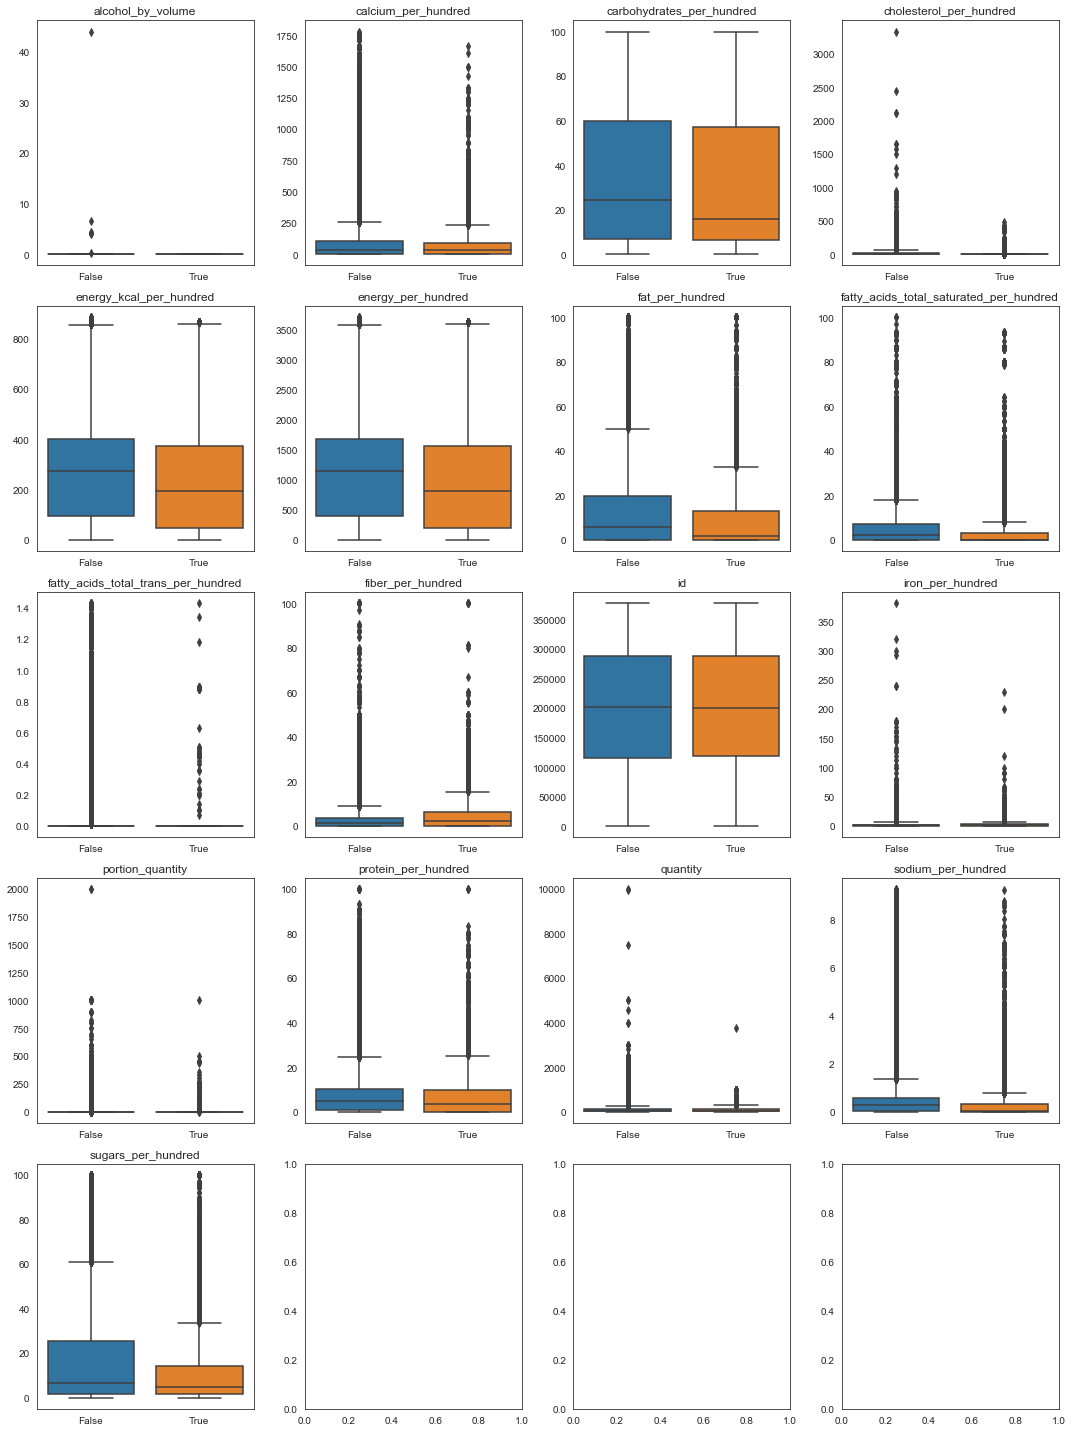

In [77]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize = (15, 20))
for i, ax in zip(range(0,len(cont_cols)), axes.ravel()):
    sns.boxplot(x='organic', y=cont_cols[i], data=df, ax=ax).set_title(cont_cols[i])
    ax.set(xlabel=None, ylabel=None)

fig.tight_layout()

Organic products seem to have less extreme values (e.g alcohol, cholesterol, fatty_acids)

#### 3. You will now focus on additives in food products. You can look for terms such as “e415”, or “e472a” in the ingredients_en column. Please note that sometimes there is a whitespace between the character e and the number following it (e.g. “e 512”).

* What are the top most common additives in the Open Food database?
* Are there countries with more or less risky additives? To help you answer this question, we provide a risky_additives.csv.zip file with a list of additives in the Resources tab.

In [78]:
df['additive'] = [list(chain(*[re.findall('^e\s?[0-9]+[a-z]?', x) 
                               for x in d.lower().split(', ') 
                               if pd.notnull(x)])) for d in df.ingredients_en.replace(np.nan,'')]

In [79]:
Counter([d.replace(' ','') for d in list(chain(*df.additive))]).most_common(10)

[('e500', 109),
 ('e475', 77),
 ('e476', 58),
 ('e450', 57),
 ('e451', 56),
 ('e331', 56),
 ('e407', 40),
 ('e471', 40),
 ('e452', 35),
 ('e415', 34)]

In [80]:
df.additive = [[w.replace(' ', '') for w in d]for d in df.additive]

In [81]:
risky = pd.read_csv('risky_additives.csv')

In [82]:
risky['additive'] = [i[0].lower() for i in risky.Additive.str.split(' ')]

In [83]:
def df_additive(country):
    l = list(chain(*df.loc[df.country==country,'additive']))
    return pd.DataFrame([np.repeat(country, len(l)), l]).T

In [84]:
df.country.unique()

array(['CH', 'FR', 'IT', 'DE', 'UK', 'US'], dtype=object)

In [85]:
additive_by_country = pd.concat([df_additive('CH'), df_additive('FR'), 
                                 df_additive('IT'), df_additive('DE'), 
                                 df_additive('UK'), df_additive('US')])

In [86]:
additive_by_country.columns = ['country','additive']

In [87]:
additive_by_country = additive_by_country.merge(risky, how='left', on='additive')

In [88]:
pd.crosstab(additive_by_country.country, additive_by_country.Risk)

Risk,High risk of over exposure,Moderate risk of over exposure,No or very low risk of over exposure
country,,,
CH,259,20,13
DE,4,1,1
IT,1,0,0
US,33,8,3


In [89]:
pd.crosstab(additive_by_country.country, additive_by_country.Risk, normalize='index').round(2)

Risk,High risk of over exposure,Moderate risk of over exposure,No or very low risk of over exposure
country,,,
CH,0.89,0.07,0.04
DE,0.67,0.17,0.17
IT,1.00,0.00,0.00
US,0.75,0.18,0.07


Switzerland has the highest percentage of risky additives, whereas Germany has the highest percentage of additives with very low or no risk.

#### 4. Your goal is to find the top common food allergens in the Open Food database. Look for common allergens in the ingredients_en column.

* What are the top common food allergens in the Open Food database?
* What is the distribution of common food allergens across countries? Is there a country with a higher percentage of products containing allergens?

Common food allergens: celery, cereals containing gluten (such as barley and oats), crustaceans (such as prawns, crabs, and lobsters), eggs, fish, lupin, milk, mollusks (such as mussels and oysters), mustard, peanuts, sesame, soybeans, tree nuts (almonds, hazelnuts, walnuts, brazil nuts, cashews, pecans, pistachios, and macadamia nuts).

In [90]:
allergens = ['celery','cereals','gluten','barley','oats','crustaceans','prawns','crabs','lobsters','eggs','fish',
             'lupin','milk','mollusks','mussels','oysters','mustard','peanuts','sesame','soybeans','nuts',
             'almonds','hazelnuts','walnuts','brazil nuts','cashews','pecans','pistachios','macadamia']

In [91]:
def transform(s):
    try: 
        s = s.lower()
        s = s.strip("[]")
        s = s.replace("(", "")
        s = s.replace(")", "")
        s = s.replace(",", "")
        s = s.replace('%', "")
        s = s.replace('*', "")
        s = s.replace(".", "")
        s = s.replace(":", "")
        s = s.replace("0", "")
        s = s.replace("1", "")
        s = s.replace("2", "")
        s = s.replace("3", "")
        s = s.replace("4", "")
        s = s.replace("5", "")
        s = s.replace("6", "")
        s = s.replace("7", "")
        s = s.replace("8", "")
        s = s.replace("9", "")
        s = re.sub('\s+', ' ', s)
        return s
    except:
        return np.nan

In [92]:
food_allergens = []

In [93]:
for d in df.ingredients_en.apply(transform):
    try:
        food_allergens.append(list(set(d.split(' ')).intersection(set(allergens))))
    except:
        food_allergens.append(set())

In [94]:
Counter(list(chain(*food_allergens))).most_common()

[('milk', 97621),
 ('barley', 22962),
 ('eggs', 17946),
 ('gluten', 15596),
 ('almonds', 13912),
 ('celery', 11533),
 ('peanuts', 10817),
 ('oats', 9690),
 ('mustard', 9460),
 ('sesame', 8856),
 ('soybeans', 7015),
 ('cashews', 5418),
 ('pecans', 3919),
 ('nuts', 3186),
 ('walnuts', 2744),
 ('hazelnuts', 2341),
 ('fish', 1508),
 ('pistachios', 957),
 ('macadamia', 641),
 ('cereals', 165),
 ('mussels', 105),
 ('oysters', 62),
 ('crustaceans', 26),
 ('mollusks', 18),
 ('lupin', 17),
 ('prawns', 9),
 ('crabs', 2)]

The most common food allergens are milk, barley, and eggs.

# D. Text data

#### 1. Which product has the longest ingredients list?

In [95]:
def transform_v2(s):
    try: 
        s = s.lower()
        s = s.strip("[]")
        s = s.replace('%', "")
        s = s.replace('*', "")
        s = s.replace(".", "")
        s = s.replace(":", "")
        s = s.replace("0", "")
        s = s.replace("1", "")
        s = s.replace("2", "")
        s = s.replace("3", "")
        s = s.replace("4", "")
        s = s.replace("5", "")
        s = s.replace("6", "")
        s = s.replace("7", "")
        s = s.replace("8", "")
        s = s.replace("9", "")
        s = re.sub('\s+', ' ', s)
        return s
    except:
        return np.nan

In [96]:
ingredients_list = pd.DataFrame([len(re.sub('\([^)]*\)', '', i).split(',')) 
                                 for i in df.ingredients_en.apply(transform_v2)
                                 if pd.notnull(i)], columns=['ingredients_length'])

In [97]:
ingredients_list['id'] = df.loc[df['ingredients_en'].notnull(),'id'].tolist()

In [98]:
df = df.merge(ingredients_list, how='left', on='id')

In [99]:
df[df.ingredients_length == max(df.ingredients_length)]

,alcohol_by_volume,barcode,calcium_per_hundred,calcium_unit,carbohydrates_per_hundred,carbohydrates_unit,cholesterol_per_hundred,cholesterol_unit,country,created_at,...,fiber_unit_max,iron_unit_max,protein_unit_max,sodium_unit_max,sugars_unit_max,above_threshold,macro_sum,organic,additive,ingredients_length
90472,0.0,0077260048356,128.0,mg,59.57,g,21.0,mg,US,2021-04-26T10:20:18.336Z,...,100.0,100000.0,100.0,100.0,100.0,0,95.88,False,[],129.0


In [100]:
df.loc[df.ingredients_length == max(df.ingredients_length),'product_name_en']

90472    RUSSELL STOVER, CAKES, COOKIES & PIES ASSORTMENT
Name: product_name_en, dtype: object

#### 2. Which products have the shortest ingredients list?

In [101]:
df.loc[df.ingredients_length == min(df.ingredients_length),'product_name_en']

1                Caffè Mauro - Roasted organic coffee blend
5                                             Knöpfli flour
6                              Naturaplan Bio Flower Honey 
22                                             Elmer: lemon
55                             Belle France: Thai long rice
                                ...                        
335139    NUTRESA, NUCITA CONO, WAFER CONE FILLED WITH C...
335140                           ANTIPODES, SPARKLING WATER
335170                               EXTRA FINE GREEN BEANS
335542                      Tadim - Roasted sunflower seeds
335575                        Kulau - Organic coconut water
Name: product_name_en, Length: 27170, dtype: object

#### 3. Which are the most frequent ingredients in products? You will also choose an appropriate method to visualize your findings.

Be careful with text normalization:

* punctuation, e.g., “water.” vs. “water”
* capitalization, e.g., “water” vs. “Water”
* white spaces removal, e.g., “ water” vs. “water”
* special characters, e.g. “raw beef [soja sauce (with ble), …]”

In [102]:
frequent_ingredients = []

In [103]:
for d in df.ingredients_en.apply(transform):
    try:
        frequent_ingredients.append(list(set(d.split(' '))))
    except:
        frequent_ingredients.append(list(set()))

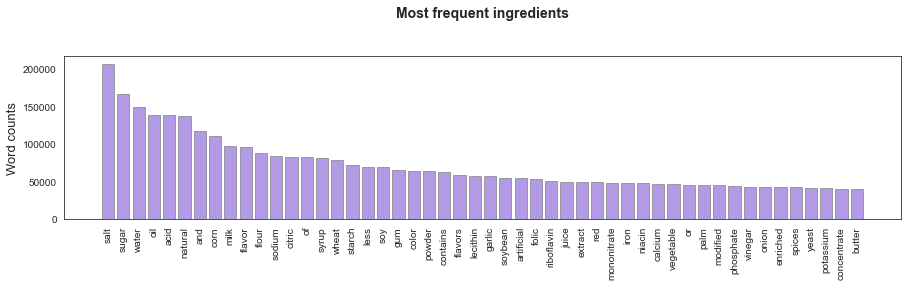

In [104]:
# Find top-50 most common words
w = Counter(list(chain(*frequent_ingredients))).most_common(50)

# Plots top words

# Barplot and font specifications
barplot_specs   = {"color": "mediumpurple", "alpha": 0.7, "edgecolor": "grey"}
title_specs     = {"fontsize": 14, "fontweight": "bold", "y": 1.2}
suptitle_specs  = {"fontsize": 11}
label_specs     = {"fontsize": 13}

plt.figure(figsize=(15,3))
plt.bar(*zip(*w), **barplot_specs)
plt.title('Most frequent ingredients', **title_specs)
plt.ylabel('Word counts', **label_specs)
plt.xticks(rotation=90)
plt.show()

The most frequent ingredients are salt, sugar, water, oil, and acid.

# E. Time-series data

#### 1. Your task is to investigate the total number of items created each month at each hour. You should use the created_at column to draw a heatmap with the hours (0 to 23) on the x-axis and the months (1 to 12) on the y-axis. The color of the heatmap should show the number of items created at each month-hour pair.

In [105]:
df.created_at = pd.to_datetime(df.created_at)

In [106]:
df['created_at_month'] = df.created_at.dt.month_name()
df['created_at_hour'] = pd.DatetimeIndex(df['created_at']).hour
df['created_at_year'] = pd.DatetimeIndex(df['created_at']).year

In [107]:
heatmap_df = df.groupby(['created_at_month','created_at_hour']).id.nunique().reset_index()

In [108]:
heatmap_df = heatmap_df.pivot(index='created_at_month', columns='created_at_hour')['id']

In [109]:
heatmap_df = heatmap_df.loc[['January','February','March','April','May','June',
                             'July','August','September','October','November','December']]

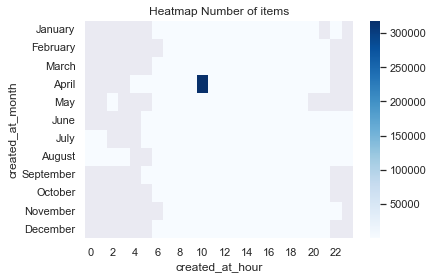

In [110]:
sns.set()
ax = sns.heatmap(heatmap_df, cmap="Blues")
plt.title("Heatmap Number of items")
plt.show()

The combination (April, 10) represents more than 80% of the data.

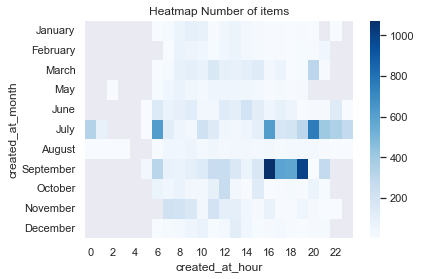

In [111]:
sns.set()
ax = sns.heatmap(heatmap_df.loc[['January','February','March','May','June',
                             'July','August','September','October','November','December']], cmap="Blues")
plt.title("Heatmap Number of items")
plt.show()

Removing the combination (April, 10), we can see that in September, at 16h and 19h, a large number of items were created.

In [112]:
Counter(df.loc[(df.created_at_month=='April') & (df.created_at_year==2021),'country'])

Counter({'CH': 172, 'DE': 1, 'FR': 1, 'US': 317672})

#### 2. Your task is to investigate the evolution of the total number of items over time. You should draw a bar plot with the date (e.g., in yyyy-mm format) on the x-axis and the total number of items created during each month on the y-axis. Each bar in the plot should stack the number of items created by each country each month. Please make sure all bars are visible by choosing the appropriate scale for the y-axis. Your output should look like the following plot.

In [113]:
df['created_at_monthyear'] = df.created_at.dt.to_period('M')

/Users/ceciliagalvan/opt/anaconda3/envs/adsml/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [114]:
barplot_df = df.groupby(['created_at_monthyear','country']).id.nunique().reset_index()

In [115]:
barplot_df = barplot_df.pivot(index='created_at_monthyear', columns='country')['id']

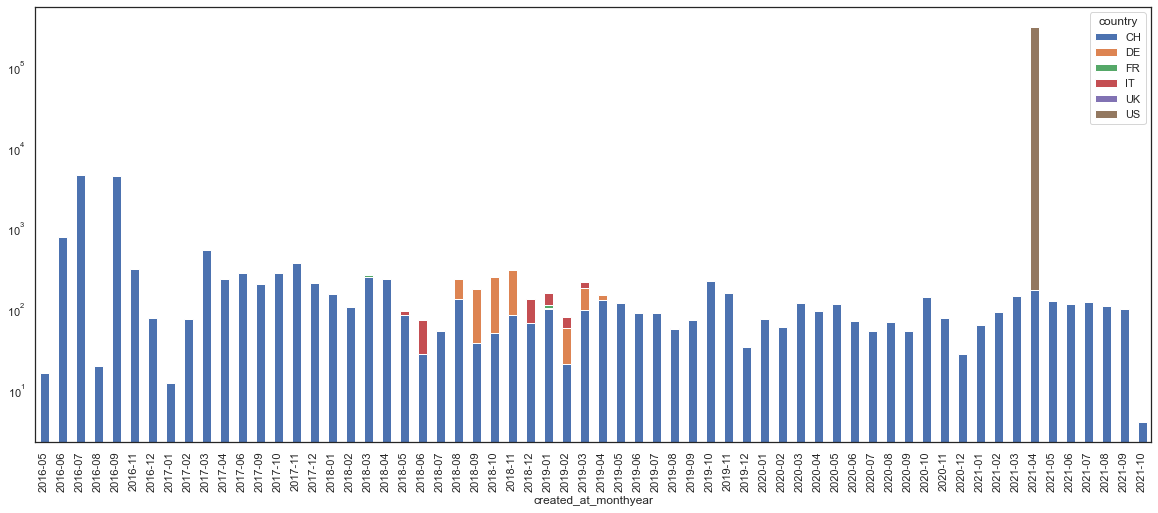

In [116]:
sns.set_style('white')
barplot_df.plot(kind='bar', stacked=True, figsize=(20,8), logy=True)
fig.tight_layout()

We see that while the swiss' total number of items over time is constant, the US number is particularly high in April 2021. The german number is condensated around end of 2018 and beginning of 2019.

# F. Correlation analysis

#### 1. Your task is to quantify the linear relationships between the energy_per_hundred and other numerical variables. Use the per_hundred columns and find their correlations with energy_per_hundred.

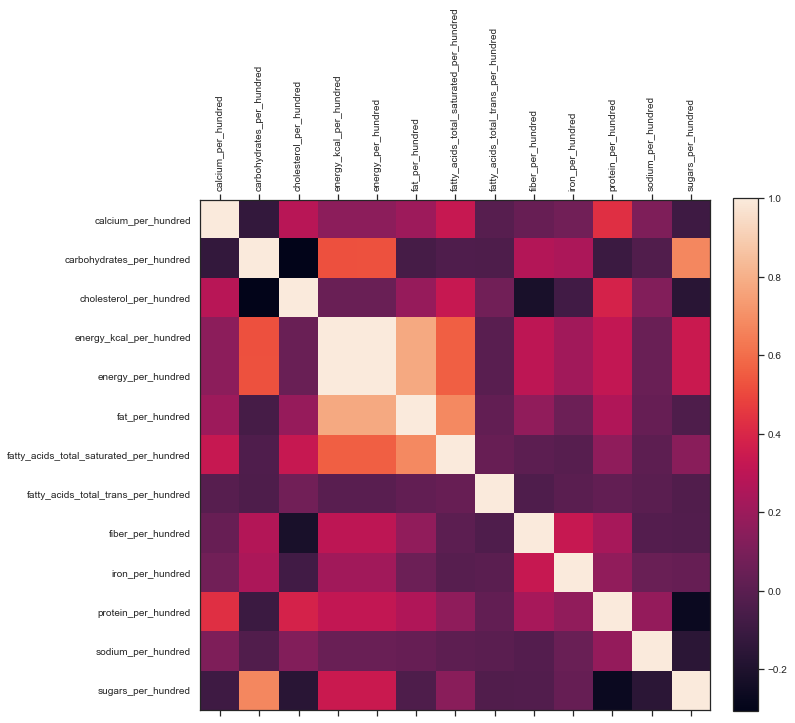

In [134]:
f = plt.figure(figsize=(10, 10))
plt.matshow(df[cols_per_hundred].corr(), fignum=f.number)
plt.xticks(range(len(cols_per_hundred)), 
           cols_per_hundred, 
           fontsize=10, 
           rotation=90)
plt.yticks(range(len(cols_per_hundred)),
           cols_per_hundred, 
           fontsize=10)
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=10)

plt.show()

In [135]:
df[cols_per_hundred].corr()

,calcium_per_hundred,carbohydrates_per_hundred,cholesterol_per_hundred,energy_kcal_per_hundred,energy_per_hundred,fat_per_hundred,fatty_acids_total_saturated_per_hundred,fatty_acids_total_trans_per_hundred,fiber_per_hundred,iron_per_hundred,protein_per_hundred,sodium_per_hundred,sugars_per_hundred
calcium_per_hundred,1.000000,-0.127952,0.286428,0.152508,0.152504,0.206228,0.334561,-0.010520,0.041628,0.072610,0.429539,0.112083,-0.089088
carbohydrates_per_hundred,-0.127952,1.000000,-0.307834,0.524562,0.525090,-0.064458,-0.034518,-0.038163,0.270167,0.252010,-0.103147,-0.031760,0.676900
cholesterol_per_hundred,0.286428,-0.307834,1.000000,0.047339,0.047337,0.182648,0.332617,0.072394,-0.218298,-0.081402,0.384700,0.122153,-0.162333
energy_kcal_per_hundred,0.152508,0.524562,0.047339,1.000000,0.999836,0.778296,0.562046,-0.001870,0.300350,0.218154,0.316127,0.048814,0.341849
energy_per_hundred,0.152504,0.525090,0.047337,0.999836,1.000000,0.777975,0.562046,-0.001870,0.300367,0.218168,0.316165,0.048786,0.342127
fat_per_hundred,0.206228,-0.064458,0.182648,0.778296,0.777975,1.000000,0.679006,0.028713,0.168985,0.059233,0.262725,0.036209,-0.041065
fatty_acids_total_saturated_per_hundred,0.334561,-0.034518,0.332617,0.562046,0.562046,0.679006,1.000000,0.044140,0.006568,-0.008385,0.165006,0.012142,0.145435
fatty_acids_total_trans_per_hundred,-0.010520,-0.038163,0.072394,-0.001870,-0.001870,0.028713,0.044140,1.000000,-0.036945,0.001453,0.025568,-0.000562,-0.026922
fiber_per_hundred,0.041628,0.270167,-0.218298,0.300350,0.300367,0.168985,0.006568,-0.036945,1.000000,0.334271,0.236317,-0.017495,-0.022113
iron_per_hundred,0.072610,0.252010,-0.081402,0.218154,0.218168,0.059233,-0.008385,0.001453,0.334271,1.000000,0.170570,0.044743,0.034462


Energy is positively and highly correlated with fat. The correlation between energy_per_hundred and fat_per_hundred is 0.777975. As expected, energy_kcal_per_hundred is perfectly correlated with energy_per_hundred (the nature of the data is identical, the change of unit did not influence the linear relationship between those features).

#### 2. Your task is to reveal the true nature of the relationship, linear or non-linear, between variables, using visualizations. Based on the correlation coefficients you found in the previous task, pick the three most correlated and the three least correlated variables (in absolute terms) with the energy_per_hundred column. Plot them against the energy_per_hundred column, using scatterplots. You should obtain these plots as subplots (with 2 rows and 3 columns) or seaborn pairplots. Please comment on the visual relationships in a markdown cell. Are they all linear? Are there still extreme values that, once removed, relationships would change?

In [159]:
df[cols_per_hundred].corr(method='pearson').energy_per_hundred.abs().sort_values(ascending=False)

energy_per_hundred                         1.000000
energy_kcal_per_hundred                    0.999836
fat_per_hundred                            0.777975
fatty_acids_total_saturated_per_hundred    0.562046
carbohydrates_per_hundred                  0.525090
sugars_per_hundred                         0.342127
protein_per_hundred                        0.316165
fiber_per_hundred                          0.300367
iron_per_hundred                           0.218168
calcium_per_hundred                        0.152504
sodium_per_hundred                         0.048786
cholesterol_per_hundred                    0.047337
fatty_acids_total_trans_per_hundred        0.001870
Name: energy_per_hundred, dtype: float64

The 3 most correlated:
* fat_per_hundred
* fatty_acids_total_saturated_per_hundred
* carbohydrates_per_hundred

The 3 least correlated:
* sodium_per_hundred
* cholesterol_per_hundred
* fatty_acids_total_trans_per_hundred

Here, energy_kcal_per_hundred will not be considered since it is the same underlying information.

In [148]:
cols_corr = ['fat_per_hundred','fatty_acids_total_saturated_per_hundred','carbohydrates_per_hundred',
             'sodium_per_hundred','cholesterol_per_hundred','fatty_acids_total_trans_per_hundred']

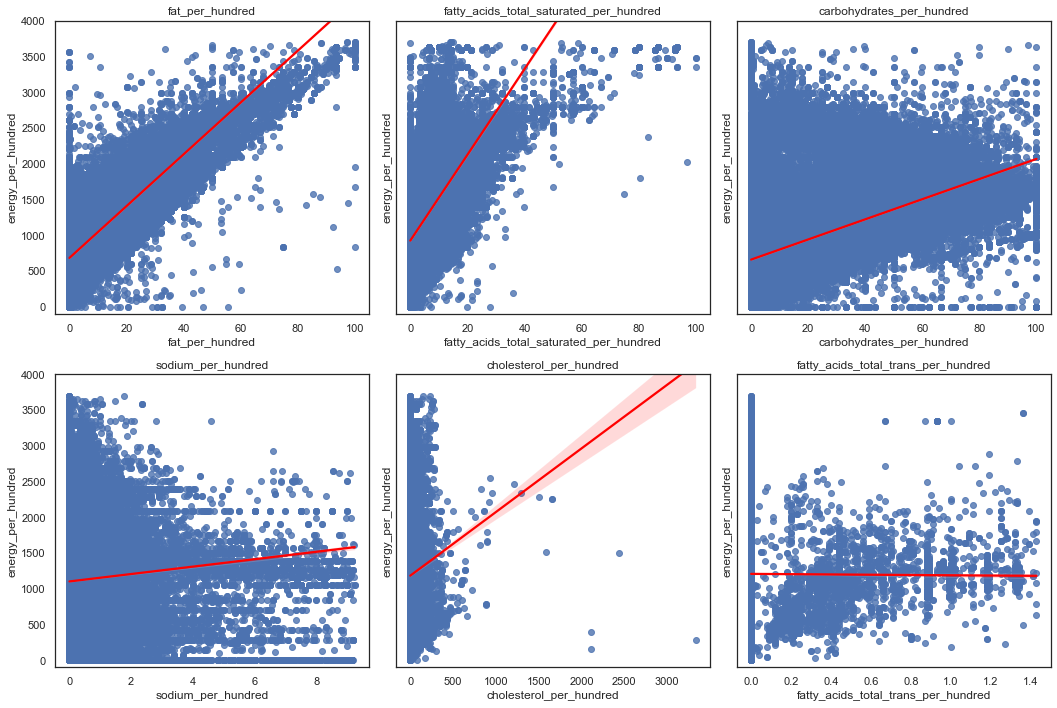

In [167]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (15, 10), sharey=True)
for i, ax in zip(range(0,len(cols_corr)), axes.ravel()):
    sns.regplot(x=cols_corr[i], y="energy_per_hundred", data=df, ax=ax, line_kws={"color": "red"})
    ax.set_title(cols_corr[i])
    # ax.set_yscale('log')
    # ax.set(xlabel=None, ylabel=None)
    # ax.set(ylim=(-100, 4000))

fig.tight_layout()

**The 3 most correlated:**

For fat_per_hundred, the majority of the points lay around a linear line, which was captured by the correlation (linear relationship). We see that the lower the correlation coefficient is, the sparser are the data points (further away from a straight line).

**The 3 least correlated:**

For none of these 3 features, the cluster of points is not "ordered" around a straight line. There is no particular shape for these relationships.

#### 3. Your task is to test the independence of two categorical variables statistically. Use the energy_per_hundred column to create a new variable with three categories low energy, medium energy and high energy. Test if the level of energy in the product is associated with the country where the product is produced.

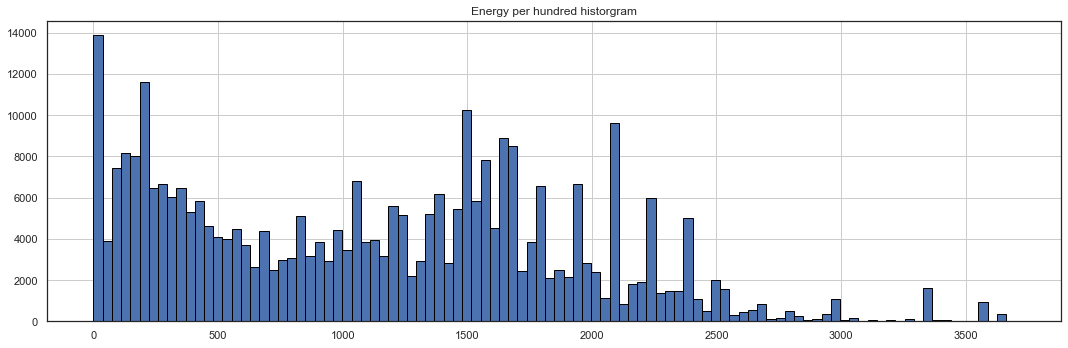

In [172]:
df['energy_per_hundred'].hist(bins=100, figsize=(15, 5), edgecolor="black").set_title('Energy per hundred historgram')
plt.tight_layout()

In [175]:
df['energy_cat'] = pd.cut(df.energy_per_hundred, bins=[0,1000, 2000, 4000], labels=['low', 'medium', 'high'])

In [188]:
# h0: there is no relationship between the level of energy in the product and the country the product is produced
# if p-value is < 5% then the h0 is rejected

In [187]:
tab = pd.crosstab(df.energy_cat, df.country)
chi_square, p_value, dof, matrix = chi2_contingency(observed=tab)

In [189]:
p_value

4.8731562424603617e-88

Because the p-value is lower than 5%, the h0 is rejected and we can conclude that there is no relationship between the level of energy and the production country.